In [2]:
import pickle

with open("../data/grow/chains_llama-3.2-3b-turbo_exp_f.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
# Filter original incorrect, knowledge incorrect
filtered_data = []

for item in data:
    filtered_model_answers_correct = []
    filtered_multihop_questions = []
    filtered_model_answers = []
    if "Unknown" not in item["model_probe_knowledge_confidence"]:
        continue
    for i, answer in enumerate(item["model_answers"]):
        if item["model_answers_correct"][i] == True:
            continue
        filtered_model_answers_correct.append(item["model_answers_correct"][i])
        filtered_multihop_questions.append(item["multihop_questions"][i])
        filtered_model_answers.append(answer)
    if len(filtered_model_answers_correct) == 0:
        continue
    item["model_answers_correct"] = filtered_model_answers_correct
    item["multihop_questions"] = filtered_multihop_questions
    item["model_answers"] = filtered_model_answers
    filtered_data.append(item)

In [12]:
filtered_data[0]

{'triples': [{'triple': ('Q102400597', 'P69', 'Q1190812'),
   'triple_label': ('Xi Ronald Chen',
    'educated at',
    'University of New Mexico')},
  {'triple': ('Q1190812', 'P159', 'Q34804'),
   'triple_label': ('University of New Mexico',
    'headquarters location',
    'Albuquerque')},
  {'triple': ('Q34804', 'P6', 'Q7807370'),
   'triple_label': ('Albuquerque', 'head of government', 'Timothy M. Keller')},
  {'triple': ('Q7807370', 'P27', 'Q30'),
   'triple_label': ('Timothy M. Keller',
    'country of citizenship',
    'United States')},
  {'triple': ('Q30', 'P35', 'Q22686'),
   'triple_label': ('United States', 'head of state', 'Donald Trump')}],
 'probe_questions': [{'question': 'Which university was Xi Ronald Chen educated at?',
   'cloze': 'The univeristy where Xi Ronald Chen was educated is ___',
   'answers': ['University of New Mexico',
    'unm.edu',
    'The University of New Mexico',
    'Universitatis Novus Mexico',
    'U.N.M.',
    'Univ. of New Mexico',
    'State 

<BarContainer object of 4 artists>

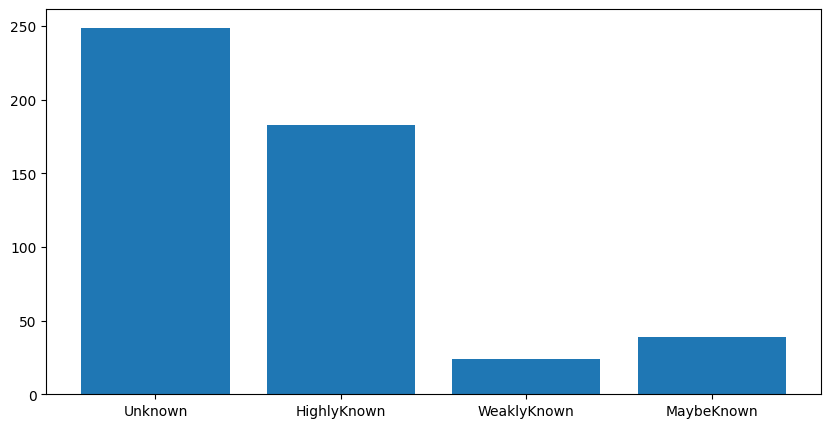

In [13]:
# Print the histogram of knowledge confidence
import matplotlib.pyplot as plt
from collections import Counter

confidence_counts = Counter()
for item in data:
    for confidence in item["model_probe_knowledge_confidence"]:
        confidence_counts[confidence] += 1
        
# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(confidence_counts.keys(), confidence_counts.values())